In [2]:
import torch
import torch.nn.functional as F
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.autograd import Variable
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from data_utils.miniplaces_dataset import  MiniPlacesDataset
from techniques.utils import pointing_game, jensenshannon, get_img_mask, get_displ_img
#from techniques.generate_grounding import gen_grounding
import torchsample

OBJ_NAMES = [
    'backpack', 'bird', 'dog', 'elephant', 'kite', 'pizza', 'stop_sign',
    'toilet', 'truck', 'zebra'
]

In [ ]:
for dirpath, dirnames, filenames in os.walk('/work/lisabdunlap/explain-eval/'):
    for d in dirnames:
        if 'pymp-' in d:
            print(dirpath+'/'+d)
            try:
                os.rmdir(dirpath+'/'+d)
            except OSError as ex:
                print(ex)

In [6]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model_state = torch.load('/work/lisabdunlap/explain-eval/training/saved/bam_explain_baseline-_checkpoint.pth.tar')
model.load_state_dict(model_state['state_dict'])
print("top 1: {0}    top 5: {1}".format(model_state['best_top1'],model_state['best_top5']))

top 1: 13.329999923706055    top 5: 64.87777709960938


In [7]:
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomSizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #torchsample.transforms.RandomRotate(30),
        torchsample.transforms.RandomGamma(0.5, 1.5),
        torchsample.transforms.RandomSaturation(-0.8, 0.8),
        torchsample.transforms.RandomBrightness(-0.3, 0.3),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        #transforms.Scale(256),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [9]:
data_dir = '/work/lisabdunlap/bam/data/obj/'

dsets = dict()
dsets['train'] = MiniPlacesDataset(
        photos_path=os.path.join(data_dir),
        labels_path=os.path.join(data_dir, 'train.txt'),
        transform=data_transforms['train'],
        train=True,
        location_paths=os.path.join(data_dir, 'loc_train.txt')
    )
dsets['val'] = MiniPlacesDataset(
        photos_path=os.path.join(data_dir),
        labels_path=os.path.join(data_dir, 'val.txt'),
        transform=data_transforms['val'],
        train=False,
        location_paths=os.path.join(data_dir, 'loc_val.txt')
    )

dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=250,
                                               shuffle=True, num_workers=25)
                for x in ['train', 'val']}

# images found at path '/work/lisabdunlap/bam/data/obj/train.txt': 90000
# images found at path '/work/lisabdunlap/bam/data/obj/val.txt': 10000


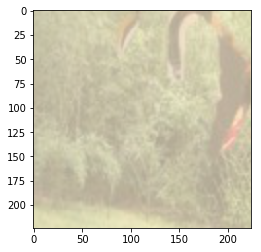

In [12]:
img, label, path, loc = dsets['val'][0]
displ_img = get_displ_img(img)
plt.imshow(displ_img)

In [10]:
for i, data in enumerate(dset_loaders['train']):
    inputs, labels, paths, locations = data
    inputs = Variable(inputs.float())
    labels = Variable(labels.long())
    outputs = model(inputs)
    _, preds1 = torch.max(outputs.data, 1)
    print('pred: ', preds1)
    print('labels: ', labels)
    #print(OBJ_NAMES[prediction[1][0].detach().numpy()[0]])
    break

pred:  tensor([5, 8, 5, 2, 9, 3, 5, 0, 8, 9, 4, 5, 9, 4, 0, 5, 9, 7, 3, 4, 5, 0, 9, 5,
        3, 1, 3, 0, 3, 5, 4, 4, 2, 3, 7, 5, 3, 7, 1, 3, 4, 4, 3, 4, 4, 0, 9, 0,
        5, 7, 7, 3, 0, 7, 7, 0, 4, 3, 7, 7, 3, 5, 5, 3, 0, 4, 4, 4, 5, 5, 3, 4,
        3, 5, 4, 3, 7, 9, 6, 5, 6, 4, 5, 4, 4, 4, 3, 3, 4, 4, 4, 5, 4, 0, 4, 9,
        3, 3, 7, 7, 0, 4, 2, 2, 9, 0, 7, 4, 9, 9, 4, 5, 0, 0, 7, 2, 8, 9, 0, 9,
        7, 3, 0, 4, 5, 0, 7, 2, 4, 9, 9, 5, 4, 0, 4, 4, 0, 3, 3, 7, 0, 6, 9, 7,
        7, 3, 7, 0, 0, 4, 5, 4, 9, 4, 7, 2, 0, 7, 4, 3, 0, 3, 3, 3, 9, 3, 5, 0,
        9, 7, 7, 0, 4, 5, 4, 0, 3, 4, 5, 0, 4, 4, 3, 4, 9, 3, 0, 5, 4, 0, 4, 3,
        4, 3, 4, 4, 0, 7, 0, 3, 8, 9, 5, 7, 0, 7, 0, 4, 5, 9, 9, 9, 4, 0, 2, 3,
        4, 3, 4, 5, 9, 8, 7, 4, 9, 9, 7, 7, 7, 9, 4, 5, 5, 4, 0, 0, 9, 3, 7, 7,
        0, 0, 4, 6, 4, 4, 4, 3, 4, 7])
labels:  tensor([5, 1, 5, 6, 9, 3, 2, 8, 8, 9, 0, 5, 9, 6, 1, 5, 9, 7, 0, 4, 5, 4, 9, 5,
        3, 4, 3, 5, 1, 6, 1, 8, 2, 3, 4, 5, 6, 8, 8, 6, 8, 6, 3, 

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/work/lisabdunlap/anaconda3/lib/python3.7/multiprocessing/util.py", line 265, in _run_finalizers
    finalizer()
  File "/work/lisabdunlap/anaconda3/lib/python3.7/multiprocessing/util.py", line 265, in _run_finalizers
    finalizer()
  File "/work/lisabdunlap/anaconda3/lib/python3.7/multiprocessing/util.py", line 189, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/work/lisabdunlap/anaconda3/lib/python3.7/multiprocessing/util.py", line 189, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/work/lisabdunlap/anaconda3/lib/python3.7/multiprocessing/util.py", line 265, in _run_finalizers
    finalizer()
  File "/work/lisabdunlap/anaconda3/lib/python3.7/multiprocessing/util.py", line 265, in _run_finalizers
    finalizer()
  File "/work/lisabdunlap/anaconda3/lib/python3.7/shutil.py", line 491, 

backpack
val/backpack-bamboo_forest-0900.jpg


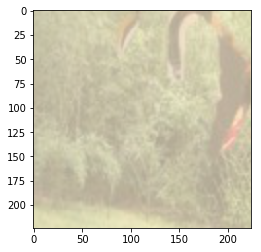

In [51]:
img, label, path, location = val_dset[0]
plt.imshow(get_displ_img(img))
print(OBJ_NAMES[label])
print(path)

In [56]:
print(img.shape)

torch.Size([3, 224, 224])


In [58]:
logits = model()
probs = F.softmax(logits, dim=1)
prediction = probs.topk(1)
print(OBJ_NAMES[prediction[1][0].detach().numpy()[0]])

ValueError: only one element tensors can be converted to Python scalars